In [225]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set()

<h2>Moore’s law</h2>

Moore's law is the observation that the number of transistors in a dense integrated circuit doubles about every two years.

Use the scripts from: https://github.com/preshing/analyze-spec-benchmarks to download a large amount of data relating to CPU specs. The script might take as long as an hour, depending on your connection speed.

This will save the data in the following format:

testID,benchName,base,peak

cpu95-19990104-03254,101.tomcatv,19.4,27.1

cpu95-19990104-03254,102.swim,27.2,34.8

cpu95-19990104-03254,103.su2cor,10.1,9.98

cpu95-19990104-03254,104.hydro2d,8.58,8.61

Now do the following:

- Extract the date and base speed for a benchmark of your choice

- Plot the data in a semi-log plot

- Now train a linear model to fit your plot

- How well is Moore’s law holding up?


In [226]:
#import the data
df = pd.read_csv('spec-data/benchmarks.txt',dtype='unicode')
df.head()

,testID,benchName,base,peak
0,cpu95-19990104-03254,101.tomcatv,19.4,27.1
1,cpu95-19990104-03254,102.swim,27.2,34.8
2,cpu95-19990104-03254,103.su2cor,10.1,9.98
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61
4,cpu95-19990104-03254,107.mgrid,8.94,9.44


In [227]:
#preprocess the data
#function to calculate difference in days between two dates
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

benchmark = df['benchName'].unique()[0] #101.tomcattv
print(f"Benchmark chosen: {benchmark}")

#extract date from test ID
new_df = df[(df['benchName'] == benchmark) & (df['testID'].str.startswith('cpu'))][['testID','base']]

#compare lengths
print(f"original length of dataset: {len(df[(df['benchName'] == benchmark)])}. After dropping invalid testIDs: {len(new_df)}")

new_df['testID'] = new_df['testID'].str[6:-6]
new_df['testID'] = pd.to_datetime(new_df['testID'])

#convert date to days, where day 0 is the first date logged
new_df['testID'] = new_df['testID'].map(lambda testID : ((testID - min(new_df['testID'])).days))

#convert base time to log
new_df['base'] = new_df['base'].astype(float)
new_df['logbase'] = np.log(new_df['base'])


Benchmark chosen: 101.tomcatv
original length of dataset: 575. After dropping invalid testIDs: 542


Text(0.5,1,'Log Base Speed of 101.tomcatv over time')

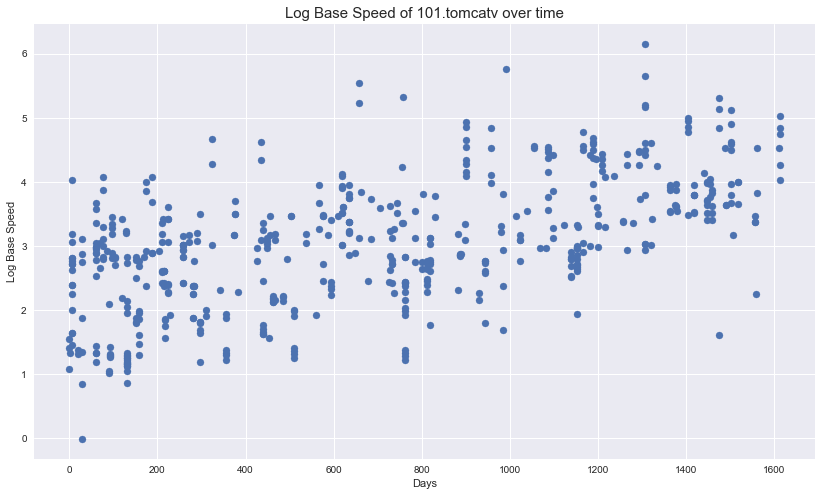

In [230]:
plt.figure(figsize=(14,8))
plt.scatter(new_df['testID'], new_df['logbase'],marker='o')
plt.xlabel("Days")
plt.ylabel("Log Base Speed")
plt.title(f"Log Base Speed of {benchmark} over time",size=15)

In [238]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#split the dataset into training and testing data
x_train,x_test,y_train,y_test = train_test_split(new_df['testID'],new_df['logbase'],test_size=0.2)

#reshape datasets
x_train,x_test,y_train,y_test = np.array(x_train).reshape(-1,1),np.array(x_test).reshape(-1,1),np.array(y_train).reshape(-1,1),np.array(y_test).reshape(-1,1)

#check the dimensions of the datasets
x_train.shape,x_test.shape,y_train.shape,y_test.shape


((433, 1), (109, 1), (433, 1), (109, 1))

In [239]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
lm = regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = lm.predict(x_test)

Coefficients: [[0.00123973]]
Mean squared error: 0.54
R^2 score: 0.35


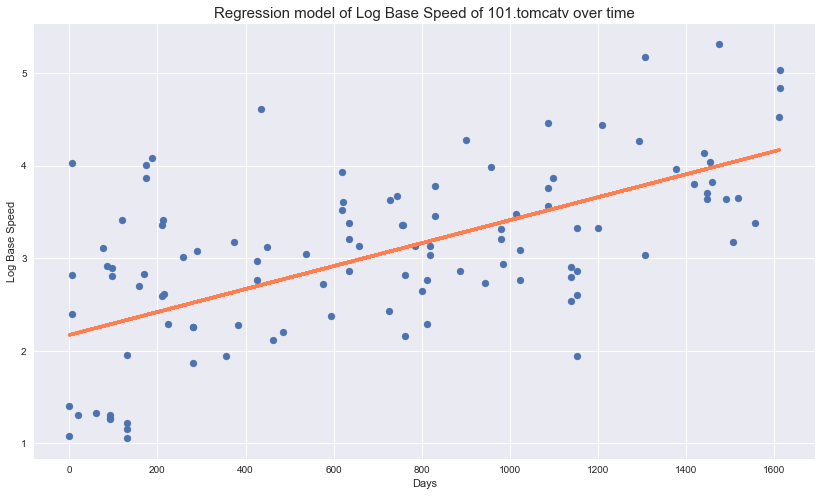

In [246]:
# The coefficients
print('Coefficients:', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R^2 score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.figure(figsize=(14,8))
plt.xlabel("Days")
plt.ylabel("Log Base Speed")
plt.title(f"Regression model of Log Base Speed of {benchmark} over time",size=15)
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred, color='coral', linewidth=3)

In [249]:
#check if number of transistors doubles every 2 years (does the base speed double every 2 years?)

#set the two years time period (the unit for time is in days)
two_yrs = 365*2

#check 10 units of two years
check_moores_x = np.array([two_yrs*i for i in range(11)])

#predict the log base speed 
check_moores_pred = lm.predict(check_moores_x.reshape(-1, 1))

#check the log base speed ratio between each two years
check_moores_ratio = [check_moores_pred[i+1]/check_moores_pred[i] for i in range(len(check_moores_pred)-1)]

for i in range(len(check_moores_ratio)):
    print(f'Ratio of year {(i+1)*2} to year {i*2}: {check_moores_ratio[i]}\n')

Ratio of year 2 to year 0: [1.41694778]

Ratio of year 4 to year 2: [1.29425769]

Ratio of year 6 to year 4: [1.22735634]

Ratio of year 8 to year 6: [1.18524069]

Ratio of year 10 to year 8: [1.15628951]

Ratio of year 12 to year 10: [1.13516469]

Ratio of year 14 to year 12: [1.11907056]

Ratio of year 16 to year 14: [1.10640129]

Ratio of year 18 to year 16: [1.09616881]

Ratio of year 20 to year 18: [1.08773175]



<h3>Conclusion</h3>

From the results above, it looks like the log base speed is not doubling every 2 years. In fact, there are increasingly smaller increments in speed as the years go by. It should be noted that these results are derived from training a linear regression model on a specific subsetted dataset (benchName == tomcattv) with 542 data points, so the results may not be generalizable to other dense integrated circuits.

<h2>Digit Recognition</h2>

No machine learning course would be complete without using the MNIST dataset. This dataset was a hugely influential dataset of handwritten digits (0-9).

Using load_digits from sklearn, a copy of the test set of the UCI ML hand-written digits datasets can be loaded to train a model to recognize handwritten digits. http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits).

- Plot some of the examples.

- Choose two digit classes (e.g 7s and 3s) , and train a k-nearest neighbor classifier.

- Report your error rates on a held out part of the data.

- (Optional) Test your model on the full MNIST dataset (available from http://yann.lecun.com/exdb/mnist/)

<h3>Part 1: Training and Testing a KNN Model using UCI ML Digit Dataset</h3>

First, we separate the UCI ML dataset into a training and testing set. There are about <b>1800 data points</b> in this dataset, and <b>64 features (8 x 8 pixel size)</b>. A KNN classifier is trained on the training set, and the model scores are reported for the testing set. We train the model on only two digits, in this case: <b>2</b> and <b>7</b>.

Size of UCI ML digit dataset: (1797, 64)


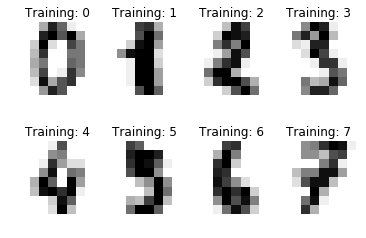

In [196]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score

digits = load_digits()
print(f"Size of UCI ML digit dataset: {digits.data.shape}")

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

data, target = digits.data, digits.target

#filter out only 2 and 7 to be used for training
two_filter = np.where((target == 2 ) | (target == 7))
data, target = data[two_filter], target[two_filter]

In [197]:
#split the dataset into training and testing data
x_train,x_test,y_train,y_test = train_test_split(data,target,test_size=0.2)

#check the dimensions of the datasets
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((284, 64), (72, 64), (284,), (72,))

In [200]:
#referenced from https://towardsdatascience.com/building-improving-a-k-nearest-neighbors-algorithm-in-python-3b6b5320d2f8
    
def skl_knn(k, test_data, test_target, train_data, train_target):
    """
    k: number of neighbors to use in classication
    test_data: the data/targets used to test the classifier
    train_data: the data/targets used to train the classifier
    """
    #create KNN classifier object
    knn = KNeighborsClassifier(n_neighbors=k)  
    #train the model
    model = knn.fit(train_data, train_target)
    #make predictions
    y_pred = knn.predict(test_data) 
    
    print(f"KNN Classifier with K-value: {k}")
    print("Accuracy score: ",accuracy_score(test_target, y_pred))
    print(classification_report(test_target, y_pred),'\n')
    
    
skl_knn(1, x_test, y_test, x_train, y_train)
skl_knn(5, x_test, y_test, x_train, y_train)
skl_knn(15, x_test, y_test, x_train, y_train)

KNN Classifier with K-value: 1
Accuracy score:  1.0
             precision    recall  f1-score   support

          2       1.00      1.00      1.00        33
          7       1.00      1.00      1.00        39

avg / total       1.00      1.00      1.00        72
 

KNN Classifier with K-value: 5
Accuracy score:  1.0
             precision    recall  f1-score   support

          2       1.00      1.00      1.00        33
          7       1.00      1.00      1.00        39

avg / total       1.00      1.00      1.00        72
 

KNN Classifier with K-value: 15
Accuracy score:  1.0
             precision    recall  f1-score   support

          2       1.00      1.00      1.00        33
          7       1.00      1.00      1.00        39

avg / total       1.00      1.00      1.00        72
 



<h3>Summary</h3>

From the classification report above, we see that after training a knn classifier using k-values of 1, 5, and 15 on the UCI ML training dataset, the classification of the digits 2 and 7 receive an accuracy, precision, and recall score 1.00 on the testing dataset. This means that the error rate is effectively 0.00 for the test set.

<h3>Part 2: Training and Testing a KNN Model using MNIST Dataset</h3>

The KNN model trained and tested in Part 1 using the UCI ML dataset is now tested on the full MNIST dataset of <b>70,000 data points</b> with <b>784 features (28 x 28 pixel size)</b>. Once again, we only test for the classification of digits <b>2</b> and <b>7</b> (since the model was only trained on digits 2 and 7).

In [181]:
#import MNIST dataset
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

Success!


In [209]:
print(f"Size of MNIST digit dataset: {mnist['data'].shape}")

#take a peak at the MNIST dataset structure
mnist

Size of MNIST digit dataset: (70000, 784)


{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original'}

In [217]:
mnist_data, mnist_target = mnist['data'], mnist['target']

#filter out only 2 and 7 to be used for training
two_filter = np.where((mnist_target == 2 ) | (mnist_target == 7))
mnist_data, mnist_target = mnist_data[two_filter], mnist_target[two_filter]

#split the dataset into training and testing data
mnist_x_train,mnist_x_test,mnist_y_train,mnist_y_test = train_test_split(mnist_data,mnist_target,test_size=0.2)

#check the dimensions of the datasets
mnist_x_train.shape,mnist_x_test.shape,mnist_y_train.shape,mnist_y_test.shape

((11426, 784), (2857, 784), (11426,), (2857,))

In [219]:
skl_knn(1, mnist_x_test, mnist_y_test, mnist_x_train, mnist_y_train)
skl_knn(5, mnist_x_test, mnist_y_test, mnist_x_train, mnist_y_train)
skl_knn(15, mnist_x_test, mnist_y_test, mnist_x_train, mnist_y_train)

KNN Classifier with K-value: 1
Accuracy score:  0.9926496324816241
             precision    recall  f1-score   support

        2.0       1.00      0.99      0.99      1376
        7.0       0.99      1.00      0.99      1481

avg / total       0.99      0.99      0.99      2857
 

KNN Classifier with K-value: 5
Accuracy score:  0.9908995449772489
             precision    recall  f1-score   support

        2.0       1.00      0.98      0.99      1376
        7.0       0.99      1.00      0.99      1481

avg / total       0.99      0.99      0.99      2857
 

KNN Classifier with K-value: 15
Accuracy score:  0.9884494224711236
             precision    recall  f1-score   support

        2.0       1.00      0.98      0.99      1376
        7.0       0.98      1.00      0.99      1481

avg / total       0.99      0.99      0.99      2857
 



<h3>Summary</h3>

From the classification report above, we see that for the MNIST dataset, using a k-value of 1 in the knn algorithm results in the highest accuracy score (0.993), followed by k-value 5 (0.991) and k-value 15 (0.988). By increasing the k-value, we are including more neighbors in the majority vote process of deciding on the final output. In this particular problem of classifying the digits of 2 and 7, more neighbors means more noise, which results in more incorrect predictions.

In terms of precision and recall scores, 2 is classified with higher precision vs recall, while 7 is classified with higher recall vs precision. This means that for 2, not all positive samples are found, but the ones that are found are all correctly classified. For 7, all the positive samples are found, but not all are correctly classified.

<h3>UCI ML Dataset Model vs MNIST Dataset Model</h3>

From the results, it appears that the KNN model trained and tested on the UCI ML dataset returns a higher accuracy score and so lower error rate vs the KNN model trained and tested on the MNIST dataset.

While these are two entirely different datasets and so should not be compared to each other, they share the similarity of being handwritten digit datasets, and being preprocessed using NIST preprocessing routines. The MNIST dataset has a larger image size (28 x 28 pixels) vs the UCI ML dataset (8 x 8 pixels), and many more data points as well (70,000 vs 1797). 

While there is more training data available for the MNIST dataset, there is also more variation and room for error (both in training the model and receiving the test score). The different preprocessing techniques might also have led to a "cleaner" dataset overall for UCI ML, which has the short-term benefit of returning higher scores for the UCI ML test set, but could lead to the long-term detriment of the model having high bias and underfitting on future data. 

In conclusion, I would prefer the MNIST-trained model over the UCIML-trained model since there were much more data points available for training and testing for the MNIST model, and the accuracy score is still relatively high, with an error rate that we would realistically expect from a human as well (some 2s and 7s could look really similar depending on the handwriting). In order to truly compare the capabilities of the two models, they would have to be tested on the same new, unseen dataset of handwritten digits. 

However, it should still be noted that the UCIML-model needs an input of 8 x 8 pixels (64 features) while the MNIST-model needs an input of 28 x 28 pixels (784 features); different digit images might have different levels of clarity and contrast based on their original size vs after compression to the appropriate input size.

References:

http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

http://yann.lecun.com/exdb/mnist/

<h3>Explanation of Classification Report</h3>

<b>Precision</b>
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

<b>Recall</b>
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

<b>f1-score</b>
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

- The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

<b>support</b>
- The support is the number of occurrences of each class in y_true.

References:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

<h2>Textbook Questions</h2>

<h3>Exercise 1.14. </h3>

A redistribution lottery involves picking the correct four numbers from 1 to 9 (without
replacement, so 3,4,4,1 for example is not possible). The order of the picked numbers is irrelevant. Every
week a million people play this game, each paying £1 to enter, with the numbers 3,5,7,9 being the most
popular (1 in every 100 people chooses these numbers). Given that the million pounds prize money is split
equally between winners, and that any four (different) numbers come up at random, what is the expected
amount of money each of the players choosing 3,5,7,9 will win each week? The least popular set of numbers
is 1,2,3,4 with only 1 in 10,000 people choosing this. How much do they profit each week, on average? Do
you think there is any ‘skill’ involved in playing this lottery?

<h3>Solution</h3>

$P($win | choose any 4 numbers without replacement$)$ = $\frac{1}{9C4} = \frac{1}{126}$

$U($win | number set$)$ = $U($reward money$) \div$ (number of people who chose number set)

$EU($win | $3579)$ = $P($win | $3579) \times U($win | $3579) = \frac{1}{126} \times 1000000 \div \frac{1000000}{100}$ = 0.79

$EU($win | $1234)$ = $P($win | $1234) \times U($win | $1234) = \frac{1}{126} \times 1000000 \div \frac{1000000}{10000}$ = 79.37

The expected amount of money each of the players choosing 3,5,7,9 will win each week is only £0.79, while the expected amount of money each of the players choosing 1,2,3,4 will win each week is £79.37.

I don't think there is any 'skill' involved in playing this lottery, but there is an element of strategy. Since each 4-number set has equal probability of being chosen each week, one should strategize to choose the least favored set since it has to be shared among the least amount of people, and so has the highest expected utility. The tricky part is figuring out which 4-number set will be the least popular.

If one could figure out the probability of each 4-number set being chosen by the general population, then one could strategically aim to choose the 4-number set with the lowest probability of being chosen. However, I still consider this a strategy and not a skill since theoretically speaking, anyone with access to these probabilities could implement the strategy as well without practice. The only skill involved might be data-gathering or calculating probabilities.

<h3>Exercise 13.5. </h3>

WowCo.com is a new startup prediction company. After years of failures, they eventually
find a neural network with a trillion hidden units that achieves zero test error on every learning problem
posted on the internet up to last week. Each learning problem included a train and test set. Proud of their
achievement, they market their product aggressively with the claim that it ‘predicts perfectly on all known
problems’. Discuss whether or not these claims would justify buying this product.

<h3>Solution</h3>

1) I would need to know their methodology. Although each learning problem included a train and test set, did they only train on the training set, or did they train on the test set as well until 0 error was achieved?

2) I would need to know the complexity of the learning problems. Achieving a 0 test error on high-dimensional, complex problems with a varied set of features would be much more difficult vs achieving a 0 test error on low-dimensional, simple problems. The harder the predictive question being answered by the problem, the more impressive the startup's algorithm is.

3) I think a difficult aspect of prediction problems is feature engineering - deciding on the features needed to inform a particular prediction would mean collecting different types of data. While one could argue that collecting more data will always lead to an improved prediction model, there are practical budgets and limitations to consider in the data collection process, alongside a potential risk of overfitting. If the learning problems consist of ideal datasets with pre-filtered "relevant" features, then they do not accurately represent the inherent noise that accompanies real world data.

4) The zero error rate might indicate that the training and testing datasets in the learning problems were idealistically "clean". Data in the real world can often be irregular, inconsistent, or vague, and so a minimum amount of error is expected to represent the inconsistent behavior of natural phenomena around us as well.

5) I would also argue that being able to "predict perfectly on all known problems" is not a sufficiently strong reason to buy their product. Oftentimes, a company or business can identify their challenges and goals, but do not know what they need to predict for or predict on in order to resolve these challenges and/or achieve these goals. If the company/businessowner already knows the answers that they want predicted, and have all the data ready for training and prediction, then perhaps purchasing the product would be justified. Otherwise, I would imagine that the hard part is figuring out what the predictive problem is first, and what data needs to be collected to solve it.

<h3>Appendix</h3>

<h4>HCs</h4>

<b>#regression:</b> I trained a simple linear regression model to predict the base speed of a given CPU benchmark based on the number of days passed since day 0, where day 0 is the first date recorded for the given CPU benchmark. I then used this predictive linear model to verify Moore's Law (it doesn't hold up). I also point out the limitations of my regression model, the key one being that it was only trained on a specific benchmark and on a limited amount of data, and so may not be representative of the general case.

<b>#expectedutility:</b> In Exercise 1.14, I calculated the expected financial utility of choosing the different sets of numbers, and took into account the probability of winning, the reward money, and the number of people that the money has to be shared with in constructing my expected utility function. While expected utility in general is a subjective concept and so would involve value assigned based on individual preference, we can make a simplification in this lottery case that the expected utility of reward money would be the same for most individuals who bought a lottery ticket, i.e. the level of risk involved is roughly the same among the participants.

<h4>Code Source</h4>

Code available at: 
https://github.com/hueyning/cs156-ml/blob/master/CS156%20Session%201.2%20-%20Basic%20classification%20and%20regression/CS156%20Session%201.2%20-%20Basic%20classification%20and%20regression.ipynb